# SVM. Метод опорных векторов

## Данные

В этой практической работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры и сравнивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - `age`
 - `workclass`
 - `fnlwgt`
 - `education`
 - `education-num`
 - `marital-status`
 - `occupation`
 - `relationship`
 - `race`
 - `sex`
 - `capital-gain`
 - `capital-loss`
 - `hours-per-week`
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Бонус ноутбука

Все исследователи данных знают, что SVM из библиотеки `sklearn` работает крайне медленно, поэтому на практике не могут его применять для решения задач.

В этом ноутбуке мы используем средства библиотеки `sklearn intelex` для ускорения обучения SVM в 600 раз! 

Ради интереса попробуйте после завершения выполнения заданий в ноутбуке удалить ячейки, связанные с установкой и импортом `sklearn intelex` и засечь время работы методов :)

In [ ]:
%%capture 
!pip install "scikit-learn-intelex<2021.5"

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from matplotlib import pyplot as plt

import sys
import os
import site
sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

In [ ]:
from sklearnex import patch_sklearn 

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики *AUC-ROC*.

Загрузим набор данных `data.adult.csv`.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/data.adult.csv")

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


In [ ]:
df.shape

(16280, 14)

Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение `numpy.nan`.  
Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?".

### Задание

Найдите все признаки, имеющие пропущенные значения.

Затем удалите из выборки все объекты с пропусками.

In [ ]:
df_test = df.replace({'?': np.nan})

In [ ]:
df_test.isna().sum()

age                 0
workclass         929
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        933
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
>50K,<=50K          0
dtype: int64

In [ ]:
df_upd = df.replace({'?': np.nan})

In [ ]:
df_upd.dropna(inplace=True)

In [ ]:
df_upd.shape

(15347, 14)

Обычно после загрузки датасета всегда необходима его некоторая предобработка.  
В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную y в отдельную переменную и преобразуйте к бинарному формату по правилу:  
 '>50K' - 1, '<=50K' - 0.
 - Выделите матрицу объект-признак `X`, содержащую только вещественные столбцы (числовые) и не содержащую целевой переменной
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [ ]:
y = df_upd['>50K,<=50K'].replace({'>50K': 1, '<=50K': 0})

In [ ]:
y.shape

(15347,)

In [ ]:
y.value_counts()

0    11407
1     3940
Name: >50K,<=50K, dtype: int64

In [ ]:
df_upd.drop(['>50K,<=50K'], axis=1, inplace=True)

In [ ]:
X = df_upd.select_dtypes(exclude='object')

In [ ]:
X.shape

(15347, 6)

### Задание

Cколько столбцов содержит матрица `X`?

Постройте гистограммы для признаков `age`, `fnlwgt`, `capital-gain`. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

Ответьте на этот вопрос для себя устно.

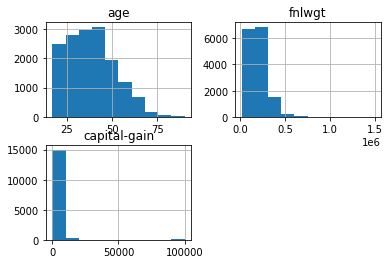

In [ ]:
X.hist(['age', 'fnlwgt', 'capital-gain']);

Масштабируйте все вещественные признаки (масштабированную матрицу назовите, как и раньше, `X`).

In [ ]:
from sklearn.preprocessing import StandardScaler

SS = StandardScaler()

In [ ]:
X = pd.DataFrame(SS.fit_transform(X), columns=X.columns)

In [ ]:
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223
1,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178
2,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379
4,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178
...,...,...,...,...,...,...
15342,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178
15343,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422
15344,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178
15345,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

Сначала обучите по кросс-валидации c **тремя** фолдами и метрикой **roc_auc** алгоритмы:
*  LogisticRegression
*  SVC(kernel='linear')

Остальные параметры оставьте по умолчанию.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# пример для логистической регрессии

cross_val_score(LogisticRegression(), X, y, cv=3, scoring='roc_auc', verbose=2).mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


0.8250515880497281

In [ ]:
# посмотрите на среднее качество SVM с линейным ядром 

cross_val_score(SVC(kernel='linear'), X, y, cv=3, scoring='roc_auc', verbose=2).mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   7.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV] END .................................................... total time=   5.7s
[CV] END .................................................... total time=   5.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.0s finished


0.8100354760945175

### Задание

Чему равно качество наилучшей из этих моделей?  
Ответ округлите до десятых.

Теперь посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать два алгоритма:
 - Logistic Regression
 - SVC (Support Vector Classifier)
 
У обоих алгоритмов будем оптимизировать гиперпараметр С, а у SVC - ещё гиперпараметр kernel.

*  Ищите C в диапазоне от 0.01 до 10.01 с шагом 0.25
*  Перебирайте ядра из списка ['rbf','poly','sigmoid','linear']

Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV (тут есть пример использования)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 3-fold cv.

In [ ]:
C = np.arange(0.01, 10.01, 0.25)

In [ ]:
# подберите C у логистической регрессии

from sklearn.model_selection import GridSearchCV

modelLR = LogisticRegression()
# parameters = {}
gs = GridSearchCV(modelLR, {'C':C}, cv=3, scoring='roc_auc')
gs.fit(X, y)

gs.best_score_, gs.best_params_

(0.825109999279449, {'C': 0.26})

In [ ]:
# так как SVM работает долго, то:
# сначала первым gridsearch подберите у метода только kernel
# вторым gridsearch для найденного ядра подберите C в диапазане от 0.01 до 2.01 с шагом 0.25

modelSVM = SVC()
gsSVM = GridSearchCV(modelSVM, {'kernel': ('linear', 'sigmoid', 'rbf', 'poly')}, cv=3, scoring='roc_auc')

gsSVM.fit(X, y)

gsSVM.best_score_, gsSVM.best_params_

(0.8100354760945175, {'kernel': 'linear'})

In [ ]:
C_new = np.arange(0.01, 2.01, 0.25)

In [ ]:
modelRBF = SVC(kernel='linear')

In [ ]:
gsRBF = GridSearchCV(modelRBF, {'C': C_new}, cv=3, scoring='roc_auc')
gsRBF.fit(X, y)

gsRBF.best_score_, gsRBF.best_params_

(0.8117049223200672, {'C': 0.01})

### Задание

Какой из алгоритмов имеет наилучшее качество? 

Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

*  Преобразуйте все категориальные признаки (исходной матрицы df) с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [`pandas.get_dummies`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html). Чтобы избежать переобучения, в `get_dummies` поставьте гиперпараметр **`drop_first=True`**.

*  Заново масштабируйте данные

In [ ]:
df_upd

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40
16276,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45
16277,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40
16278,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40


In [ ]:
X_new = pd.get_dummies(df_upd, drop_first=True)
X_new.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,34,284843,9,594,0,60,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,40,190290,10,0,0,40,0,1,0,0,...,1,0,0,0,0,0,0,0,1,1
2,36,177858,13,0,0,40,1,0,0,0,...,0,0,1,0,0,0,0,0,1,1
3,22,184756,10,0,0,30,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,47,149700,13,15024,0,40,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1


In [ ]:
X_new = pd.DataFrame(SS.fit_transform(X_new), columns=X_new.columns)

In [ ]:
X_new

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223,3.658322,-1.665953,-0.194785,-0.307272,...,1.711163,-0.175191,-0.416530,-0.338654,-0.227941,-0.182943,3.101735,-0.08727,-2.443271,0.686401
1,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178,-0.273349,0.600257,-0.194785,-0.307272,...,1.711163,-0.175191,-0.416530,-0.338654,-0.227941,-0.182943,-0.322400,-0.08727,0.409287,0.686401
2,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178,3.658322,-1.665953,-0.194785,-0.307272,...,-0.584398,-0.175191,2.400786,-0.338654,-0.227941,-0.182943,-0.322400,-0.08727,0.409287,0.686401
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379,-0.273349,0.600257,-0.194785,-0.307272,...,-0.584398,-0.175191,2.400786,-0.338654,-0.227941,-0.182943,-0.322400,-0.08727,0.409287,-1.456874
4,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178,-0.273349,0.600257,-0.194785,-0.307272,...,-0.584398,-0.175191,-0.416530,-0.338654,-0.227941,-0.182943,-0.322400,-0.08727,0.409287,0.686401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178,3.658322,-1.665953,-0.194785,-0.307272,...,-0.584398,-0.175191,2.400786,-0.338654,-0.227941,-0.182943,3.101735,-0.08727,-2.443271,-1.456874
15343,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422,-0.273349,0.600257,-0.194785,-0.307272,...,-0.584398,-0.175191,-0.416530,-0.338654,-0.227941,-0.182943,-0.322400,-0.08727,0.409287,0.686401
15344,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178,-0.273349,0.600257,-0.194785,-0.307272,...,1.711163,-0.175191,-0.416530,-0.338654,-0.227941,5.466194,-0.322400,-0.08727,-2.443271,0.686401
15345,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178,-0.273349,-1.665953,-0.194785,-0.307272,...,-0.584398,-0.175191,-0.416530,-0.338654,-0.227941,-0.182943,-0.322400,-0.08727,0.409287,0.686401


Так как после кодирования признаков получилось достаточно много, в этой работе мы не будем добавлять их и подбирать заново оптимальные гиперпараметры. 

Обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 3-Fold CV в функции `cross_val_score`.

In [ ]:
cross_val_score(LogisticRegression(C=0.26), X_new, y, cv=3, scoring='roc_auc', verbose=2).mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


0.9027489658933026

In [ ]:
cross_val_score(SVC(kernel='linear', C=0.01), X_new, y, cv=3, scoring='roc_auc', verbose=2).mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   3.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] END .................................................... total time=   3.6s
[CV] END .................................................... total time=   3.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.3s finished


0.8981838913603667

Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

Не отличается

### Задание

*  Разбейте данные на тренировочную и тестовую часть (либо данные только с числовыми признаками, либо данные после OneHot-кодировки - в зависимости от того, на каких данных модели лучше отработали). 

**Вопрос:**  
стали ли модели лучше решать задачу при добавлении закодированных категориальных признаков?

*test_size = 0.25, random_state = 42*

* Cреди всех обученных в работе моделей возьмите наилучшую (по roc-auc).
Заново обучите эту модель на тренировочных данных, сделайте предсказание на тесте.

* Постройте roc-кривую и отметьте на ней значение roc-auc - по тестовым данным.

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.metrics import roc_curve, auc

best_model = LogisticRegression(C=0.26).fit(Xtrain, ytrain)

In [ ]:
best_pred = best_model.predict(Xtest)

In [ ]:
fpr, tpr, thresh = roc_curve(ytest, best_pred)

In [ ]:
fpr, tpr

(array([0.        , 0.07175359, 1.        ]),
 array([0.        , 0.60510204, 1.        ]))

In [ ]:
roc_auc = auc(fpr, tpr)

In [ ]:
roc_auc

0.7666742265684712

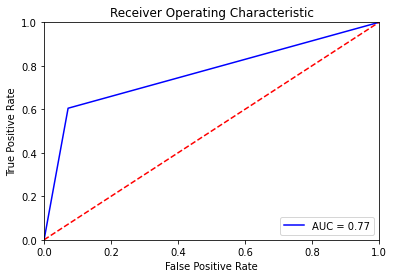

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

### Задание

In [ ]:
roc_auc_score(ytest, best_pred)

0.7666742265684713

Чему равен `roc-auc` наилучшей модели на тестовых данных?

In [ ]:
model2 = SVC(kernel='linear', C=0.01).fit(Xtrain, ytrain)

In [ ]:
ypred = model2.predict(Xtest)

In [ ]:
roc_auc_score(ytest, ypred)

0.754533083797047